# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [247]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [248]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 20000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (20000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [249]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [250]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [251]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [252]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [253]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [254]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [255]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(19354, 10)

In [256]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

96.77

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [257]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [258]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [259]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(19354, 10)


1    16339
0     3015
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [260]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
I received this box with great anticipation since they don't sell these on the west coast. I got the package, opened the box and was EXTREMELY disappointed. The cookies looked like a gorilla shook the box to death and left most of the box filled with crumbs. AND THERE WAS A RODENT SIZED HOLE ON THE SIDE OF THE BOX!!!!!!!! So, needless to say I will not NOT be reordering these again.
I have two cats. My big boy has eaten these and never had a problem...as a matter of fact he has never vomited or had a hair ball since I adopted him at 2 months. My girl cat throws up every time she eats this particular flavor. Since I treat them equally these are no longer purchased. I hate to see my girl sick so I just recommend you watch your cats after you give them these treats. If not a problem...carry on.
I was always a fan of Dave's, so I bought this at a local store to try Blair's and I'm glad I did.  The jalepeno saus

In [261]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!


In [262]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
I received this box with great anticipation since they don't sell these on the west coast. I got the package, opened the box and was EXTREMELY disappointed. The cookies looked like a gorilla shook the box to death and left most of the box filled with crumbs. AND THERE WAS A RODENT SIZED HOLE ON THE SIDE OF THE BOX!!!!!!!! So, needless to say I will not NOT be reordering these again.
I have two cats. My big boy has eaten these and never had a problem...as a matter of fact he has never vomited or had a hair ball since I adopted him at 2 months. My girl cat throws up every time she eats this particular flavor. Since I treat them equally these are no longer purchased. I hate to see my girl sick so I just recommend you watch your cats after you give them these treats. If not a problem...carry on.
I was always a fan of Dave's, so I bought this at a local store to try Blair's and I'm glad I did.  The jalepeno saus

In [263]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [264]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I have two cats. My big boy has eaten these and never had a problem...as a matter of fact he has never vomited or had a hair ball since I adopted him at 2 months. My girl cat throws up every time she eats this particular flavor. Since I treat them equally these are no longer purchased. I hate to see my girl sick so I just recommend you watch your cats after you give them these treats. If not a problem...carry on.


In [265]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

We have used the Victor fly bait for  seasons.  Can't beat it.  Great product!


In [266]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I have two cats My big boy has eaten these and never had a problem as a matter of fact he has never vomited or had a hair ball since I adopted him at 2 months My girl cat throws up every time she eats this particular flavor Since I treat them equally these are no longer purchased I hate to see my girl sick so I just recommend you watch your cats after you give them these treats If not a problem carry on 


In [267]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [268]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 19354/19354 [00:08<00:00, 2203.93it/s]


In [269]:
preprocessed_reviews[1500]

'two cats big boy eaten never problem matter fact never vomited hair ball since adopted months girl cat throws every time eats particular flavor since treat equally no longer purchased hate see girl sick recommend watch cats give treats not problem carry'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [270]:
X = preprocessed_reviews
Y = final['Score']

In [271]:
from sklearn.cross_validation import train_test_split
X_1 , X_test , Y_1 , Y_test  = train_test_split(X,Y,test_size=0.3,random_state=0)
X_tr , X_cv , Y_tr , Y_cv  = train_test_split(X_1,Y_1,test_size=0.3,random_state=0)

In [272]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [273]:
##BoW
count_vect = CountVectorizer( min_df=20, max_df=50) #in scikit-learn
count_vect.fit(X_tr)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)


X_Bow_Tr = count_vect.transform(X_tr)
X_Bow_Cv = count_vect.transform(X_cv)
X_Bow_Test = count_vect.transform(X_test)

print("the type of count vectorizer ",type(X_Bow_Tr))
print("the shape of out text BOW vectorizer ",X_Bow_Tr.get_shape())
print("the number of unique words ", X_Bow_Tr.get_shape()[1])

some feature names  ['absolute', 'according', 'acidic', 'active', 'actual', 'addictive', 'additives', 'adult', 'adults', 'afford']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (9482, 1119)
the number of unique words  1119


In [274]:
Bow_Feature = count_vect.get_feature_names()
X_Bow_Tr = X_Bow_Tr.toarray()
X_Bow_Cv = X_Bow_Cv.toarray()
X_Bow_Test = X_Bow_Test.toarray()

## [4.3] TF-IDF

In [275]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=20, max_df=50)
tf_idf_vect.fit(X_tr)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)


X_Tfidf_Tr = tf_idf_vect.transform(X_tr)
X_Tfidf_Cv = tf_idf_vect.transform(X_cv)
X_Tfidf_Test = tf_idf_vect.transform(X_test)

print("the type of count vectorizer ",type(X_Tfidf_Tr))
print("the shape of out text TFIDF vectorizer ",X_Tfidf_Tr.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_Tfidf_Tr.get_shape()[1])

some sample features(unique words in the corpus) ['able find', 'able get', 'absolute', 'absolutely delicious', 'absolutely loves', 'according', 'acidic', 'active', 'actual', 'add little']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (9482, 1760)
the number of unique words including both unigrams and bigrams  1760


In [276]:
X_Tfidf_Tr = X_Tfidf_Tr.toarray()
X_Tfidf_Cv = X_Tfidf_Cv.toarray()
X_Tfidf_Test = X_Tfidf_Test.toarray()
tf_idf_feature = tf_idf_vect.get_feature_names()

## [4.4] Word2Vec

In [277]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [278]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8423455953598022), ('good', 0.8371583223342896), ('fantastic', 0.8326070308685303), ('excellent', 0.8148292303085327), ('wonderful', 0.8053280115127563), ('amazing', 0.7542715668678284), ('decent', 0.7345545887947083), ('delicious', 0.7005295753479004), ('perfect', 0.694447934627533), ('especially', 0.6708776950836182)]
[('closest', 0.8194966316223145), ('personal', 0.8029736280441284), ('disappointing', 0.798120379447937), ('sf', 0.7805026173591614), ('greatest', 0.7757930159568787), ('surpasses', 0.7696995139122009), ('best', 0.7687111496925354), ('fav', 0.7664926052093506), ('bye', 0.7653446197509766), ('quenching', 0.7647767663002014)]


In [279]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  8370
sample words  ['used', 'fly', 'bait', 'seasons', 'ca', 'not', 'beat', 'great', 'product', 'available', 'traps', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'really', 'good', 'idea', 'final', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'bought', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'stickers', 'removed', 'easily', 'daughter', 'designed', 'signs', 'printed', 'reverse', 'windows', 'beautifully']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [353]:
# average Word2Vec
# compute average word2vec for each review.

def getAvgWordToVector(list_of_sentance):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list    
    for sentence in list_of_sentance: # for each review/sentence
        sent = sentence.split()
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]                
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)                   
    return sent_vectors

In [354]:
X_AvgW2V_Tr     = getAvgWordToVector(X_tr)
X_AvgW2V_Cv     = getAvgWordToVector(X_cv)
X_AvgW2V_Test   = getAvgWordToVector(X_test)

In [360]:
X_AvgW2V_Tr     = np.array(X_AvgW2V_Tr)
X_AvgW2V_Cv     = np.array(X_AvgW2V_Cv)
X_AvgW2V_Test   = np.array(X_AvgW2V_Test)

#### [4.4.1.2] TFIDF weighted W2v

In [282]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [283]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

def getAvgW2VtfIdfToVector(list_of_sentance):
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sentence in list_of_sentance: # for each review/sentence 
        sent = []
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        sent = sentence.split()
        for word in sent: # for each word in a review/sentence3        
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

In [284]:
X_AvgW2VtfIdf_Tr     = getAvgW2VtfIdfToVector(X_tr)
X_AvgW2VtfIdf_Cv     = getAvgW2VtfIdfToVector(X_cv)
X_AvgW2VtfIdf_Test   = getAvgW2VtfIdfToVector(X_test)

In [367]:
X_AvgW2VtfIdf_Tr     = np.array(X_AvgW2VtfIdf_Tr)
X_AvgW2VtfIdf_Cv     = np.array(X_AvgW2VtfIdf_Cv)
X_AvgW2VtfIdf_Test   = np.array(X_AvgW2VtfIdf_Test)

## [5.2] Applying GBDT using XGBOOST

### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

In [319]:
import xgboost as xgb
xparams = { 
    'n_estimators':[50,100,200,300],
    'max_depth' : [2,3,4,5],
    'learning_rate' : [0.1,0.4,0.6, 0.8]
}

In [320]:
#https://www.kaggle.com/phunter/xgboost-with-gridsearchcv
Xboost  = xgb.XGBClassifier( objective='binary:logistic', booster='gbtree', n_jobs=-1)
cv_xgb = GridSearchCV(Xboost, xparams, cv=5,scoring='roc_auc')

cv_xgb.fit(X_Bow_Cv, Y_cv)

print('Best Parameters using grid search: \n',cv_xgb.best_params_,"\n\n")
Set5_Cv_Results = pd.DataFrame(cv_xgb.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
Set5_Cv_Results

Best Parameters using grid search: 
 {'learning_rate': 0.4, 'max_depth': 4, 'n_estimators': 300} 




,mean_test_score,std_test_score,params
0,0.583971,0.026429,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti..."
1,0.609020,0.028693,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti..."
2,0.633208,0.038996,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti..."
3,0.652420,0.034827,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti..."
4,0.604085,0.024202,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
5,0.634283,0.033067,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
6,0.657051,0.028733,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
7,0.674347,0.031462,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
8,0.617843,0.021435,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti..."
9,0.644556,0.029205,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti..."


In [324]:
#examine the best model
print("\t best_score_     :",cv_xgb.best_score_)
print("\t best_params_    :",cv_xgb.best_params_)
#print(" best_estimator_ :",cv_xgb.best_estimator_)
Set5_best             = cv_xgb.best_params_
Set5_best_max_depth   =  cv_xgb.best_params_['max_depth']
Set5_best_estimator   =  cv_xgb.best_params_['n_estimators']
Set5_best_V           =  cv_xgb.best_params_['learning_rate']
Set5_Cv_AUC           =  cv_xgb.best_score_

	 best_score_     : 0.7024611414356837
	 best_params_    : {'learning_rate': 0.4, 'max_depth': 4, 'n_estimators': 300}


In [325]:
Set5_Weights = []
Xboost = xgb.XGBClassifier(n_estimator=Set5_best_estimator,max_depth=Set5_best_max_depth,learning_rate=Set5_best_V,objective='binary:logistic', booster='gbtree', n_jobs=-1)
Xboost.fit(X_Bow_Tr,Y_tr)
Set5_Weights = rf.feature_importances_.tolist()

 Train Data      AUC for the Best Lamda  is  0.8216849910086517
 Test Validaton  AUC for the BEst Lamda  is  0.7251634751281193


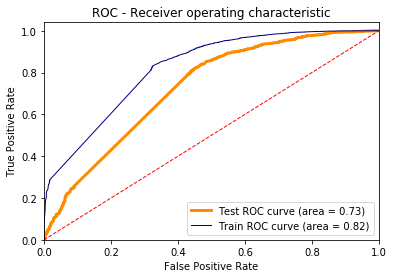

In [326]:
#https://qiita.com/bmj0114/items/460424c110a8ce22d945
Set5_Tr_prob    =  Xboost.predict_proba(X_Bow_Tr)    # Probablity of TRAIN-Validation
Set5_Tst_prob   =  Xboost.predict_proba(X_Bow_Test)    # Probablity of Cross-Validation

Set5_tst_fpr, Set5_tst_tpr, thresholds = roc_curve(Y_test,Set5_Tst_prob[:,1])
Set5_tst_roc_auc = auc(Set5_tst_fpr, Set5_tst_tpr)

Set5_train_fpr, Set5_train_tpr, thresholds = roc_curve(Y_tr,Set5_Tr_prob[:,1])
Set5_train_roc_auc = auc(Set5_train_fpr, Set5_train_tpr)


print(" Train Data      AUC for the Best Lamda  is ", Set5_train_roc_auc)
print(" Test Validaton  AUC for the BEst Lamda  is ", Set5_tst_roc_auc)

lw=1
plt.figure()
plt.plot(Set5_tst_fpr, Set5_tst_tpr, color='darkorange', lw=3, label='Test ROC curve (area = %0.2f)' % Set5_tst_roc_auc)
plt.plot(Set5_train_fpr, Set5_train_tpr, color='navy', lw=1, label='Train ROC curve (area = %0.2f)' % Set5_train_roc_auc)
plt.plot([0, 1], [0,1], color='red', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.04])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

In [327]:
# Top Important features
Set5_Imp_Features=pd.DataFrame([Bow_Feature,Set5_Weights],index=['feature','Decision_Imp']).T
#Set5_Imp_Features= Set5_Imp_Features[(Set5_Imp_Features['Decision_Imp']>0)]
Set5_Imp_Features_sortd = Set5_Imp_Features.sort_values(by='Decision_Imp')[-20:][::-1]

### [5.2.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

In [331]:
# Please write all the code with proper documentation

In [334]:
Xboost  = xgb.XGBClassifier( objective='binary:logistic', booster='gbtree', n_jobs=-1)
cv_xgb = GridSearchCV(Xboost, xparams, cv=5,scoring='roc_auc')
cv_xgb.fit(X_Tfidf_Cv, Y_cv)


print('Best Parameters using grid search: \n',cv_xgb.best_params_,"\n\n")
Set6_Cv_Results = pd.DataFrame(cv_xgb.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
Set6_Cv_Results

Best Parameters using grid search: 
 {'learning_rate': 0.4, 'max_depth': 4, 'n_estimators': 200} 




,mean_test_score,std_test_score,params
0,0.601812,0.033014,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti..."
1,0.647497,0.026667,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti..."
2,0.668549,0.022956,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti..."
3,0.683672,0.032498,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti..."
4,0.631325,0.025754,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
5,0.658002,0.024343,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
6,0.683384,0.032863,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
7,0.695878,0.033638,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
8,0.646317,0.025751,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti..."
9,0.670791,0.022324,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti..."


In [335]:
#examine the best model
print("\t best_score_     :",cv_xgb.best_score_)
print("\t best_params_    :",cv_xgb.best_params_)
#print(" best_estimator_ :",cv_xgb.best_estimator_)
Set6_best             = cv_xgb.best_params_
Set6_best_max_depth   =  cv_xgb.best_params_['max_depth']
Set6_best_estimator   =  cv_xgb.best_params_['n_estimators']
Set6_best_V           =  cv_xgb.best_params_['learning_rate']
Set6_Cv_AUC           =  cv_xgb.best_score_

	 best_score_     : 0.7385034177363529
	 best_params_    : {'learning_rate': 0.4, 'max_depth': 4, 'n_estimators': 200}


In [336]:
Set6_Weights = []
Xboost = xgb.XGBClassifier(n_estimator=Set5_best_estimator,max_depth=Set5_best_max_depth,learning_rate=Set5_best_V,objective='binary:logistic', booster='gbtree', n_jobs=-1)
Xboost.fit(X_Tfidf_Tr,Y_tr)
Set6_Weights = Xboost.feature_importances_.tolist()

 Train Data      AUC for the Best Lamda  is  0.8745829517596073
 Test Validaton  AUC for the BEst Lamda  is  0.7575635293403067


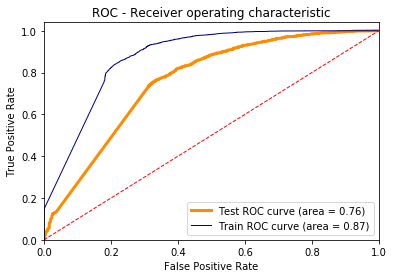

In [337]:

#https://qiita.com/bmj0114/items/460424c110a8ce22d945
Set6_Tr_prob    =  Xboost.predict_proba(X_Tfidf_Tr)    # Probablity of TRAIN-Validation
Set6_Tst_prob   =  Xboost.predict_proba(X_Tfidf_Test)    # Probablity of Cross-Validation

Set6_tst_fpr, Set6_tst_tpr, thresholds = roc_curve(Y_test,Set6_Tst_prob[:,1])
Set6_tst_roc_auc = auc(Set6_tst_fpr, Set6_tst_tpr)

Set6_train_fpr, Set6_train_tpr, thresholds = roc_curve(Y_tr,Set6_Tr_prob[:,1])
Set6_train_roc_auc = auc(Set6_train_fpr, Set6_train_tpr)


print(" Train Data      AUC for the Best Lamda  is ", Set6_train_roc_auc)
print(" Test Validaton  AUC for the BEst Lamda  is ", Set6_tst_roc_auc)

lw=1
plt.figure()
plt.plot(Set6_tst_fpr, Set6_tst_tpr, color='darkorange', lw=3, label='Test ROC curve (area = %0.2f)' % Set6_tst_roc_auc)
plt.plot(Set6_train_fpr, Set6_train_tpr, color='navy', lw=1, label='Train ROC curve (area = %0.2f)' % Set6_train_roc_auc)
plt.plot([0, 1], [0,1], color='red', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.04])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### [5.2.2] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

In [339]:
# Top Important features
Set6_Imp_Features=pd.DataFrame([tf_idf_feature,Set6_Weights],index=['feature','Decision_Imp']).T
#Set6_Imp_Features= Set6_Imp_Features[(Set6_Imp_Features['Decision_Imp']>0)]
Set6_Imp_Features_sortd = Set6_Imp_Features.sort_values(by='Decision_Imp')[-20:][::-1]

### [5.2.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

In [361]:
Xboost = xgb.XGBClassifier(objective='binary:logistic', booster='gbtree', n_jobs=-1)
cv_xgb = GridSearchCV(Xboost,xparams, cv=5,scoring='roc_auc')
cv_xgb.fit(X_AvgW2V_Cv,Y_cv)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 100, 200, 300], 'max_depth': [2, 3, 4, 5], 'learning_rate': [0.1, 0.4, 0.6, 0.8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [362]:
#examine the best model
print("\t best_score_     :",cv_xgb.best_score_)
print("\t best_params_    :",cv_xgb.best_params_)
#print(" best_estimator_ :",cv_xgb.best_estimator_)
Set7_best             = cv_xgb.best_params_
Set7_best_max_depth   =  cv_xgb.best_params_['max_depth']
Set7_best_estimator   =  cv_xgb.best_params_['n_estimators']
Set7_best_V           =  cv_xgb.best_params_['learning_rate']
Set7_Cv_AUC           =  cv_xgb.best_score_

	 best_score_     : 0.8730882223343447
	 best_params_    : {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 300}


In [363]:
Set7_Weights = []
Xboost = xgb.XGBClassifier(n_estimator=Set5_best_estimator,max_depth=Set5_best_max_depth,learning_rate=Set5_best_V,objective='binary:logistic', booster='gbtree', n_jobs=-1)
Xboost.fit(X_AvgW2V_Tr,Y_tr)
Set7_Weights = Xboost.feature_importances_.tolist()

 Train Data      AUC for the Best Lamda  is  0.997370169985069
 Test Validaton  AUC for the BEst Lamda  is  0.8581519536784963


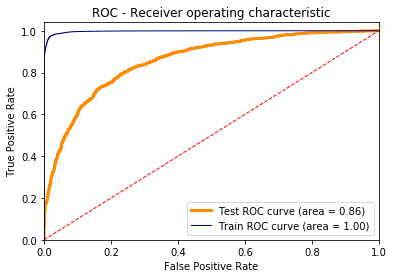

In [364]:

#https://qiita.com/bmj0114/items/460424c110a8ce22d945
Set7_Tr_prob    =  Xboost.predict_proba(X_AvgW2V_Tr)    # Probablity of TRAIN-Validation
Set7_Tst_prob   =  Xboost.predict_proba(X_AvgW2V_Test)    # Probablity of Cross-Validation

Set7_tst_fpr, Set7_tst_tpr, thresholds = roc_curve(Y_test,Set7_Tst_prob[:,1])
Set7_tst_roc_auc = auc(Set7_tst_fpr, Set7_tst_tpr)

Set7_train_fpr, Set7_train_tpr, thresholds = roc_curve(Y_tr,Set7_Tr_prob[:,1])
Set7_train_roc_auc = auc(Set7_train_fpr, Set7_train_tpr)


print(" Train Data      AUC for the Best Lamda  is ", Set7_train_roc_auc)
print(" Test Validaton  AUC for the BEst Lamda  is ", Set7_tst_roc_auc)

lw=1
plt.figure()
plt.plot(Set7_tst_fpr, Set7_tst_tpr, color='darkorange', lw=3, label='Test ROC curve (area = %0.2f)' % Set7_tst_roc_auc)
plt.plot(Set7_train_fpr, Set7_train_tpr, color='navy', lw=1, label='Train ROC curve (area = %0.2f)' % Set7_train_roc_auc)
plt.plot([0, 1], [0,1], color='red', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.04])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### [5.2.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

In [368]:
# Please write all the code with proper documentation

In [369]:
Xboost  = xgb.XGBClassifier( objective='binary:logistic', booster='gbtree', n_jobs=-1)
cv_xgb = GridSearchCV(Xboost, xparams, cv=5,scoring='roc_auc')
cv_xgb.fit(X_AvgW2VtfIdf_Cv, Y_cv)

print('Best Parameters using grid search: \n',cv_xgb.best_params_,"\n\n")
Set8_Cv_Results = pd.DataFrame(cv_xgb.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
print(Set8_Cv_Results)

Best Parameters using grid search: 
 {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200} 


    mean_test_score  std_test_score  \
0          0.828282        0.017567   
1          0.839048        0.016775   
2          0.842876        0.016905   
3          0.843751        0.016564   
4          0.840412        0.017385   
5          0.846495        0.017426   
6          0.847176        0.016653   
7          0.843781        0.016244   
8          0.842397        0.016796   
9          0.846831        0.019428   
10         0.846836        0.019304   
11         0.844597        0.017499   
12         0.847722        0.016116   
13         0.848176        0.015834   
14         0.848187        0.016856   
15         0.846773        0.017653   
16         0.839076        0.017794   
17         0.831676        0.017332   
18         0.828553        0.017614   
19         0.828169        0.016058   
20         0.833663        0.016972   
21         0.830750        0.013346   
22 

In [370]:
#examine the best model
print("\t best_score_     :",cv_xgb.best_score_)
print("\t best_params_    :",cv_xgb.best_params_)
#print(" best_estimator_ :",cv_xgb.best_estimator_)
Set8_best             = cv_xgb.best_params_
Set8_best_max_depth   =  cv_xgb.best_params_['max_depth']
Set8_best_estimator   =  cv_xgb.best_params_['n_estimators']
Set8_best_V           =  cv_xgb.best_params_['learning_rate']
Set8_Cv_AUC           =  cv_xgb.best_score_

	 best_score_     : 0.8481869756997356
	 best_params_    : {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


In [371]:
Set8_Weights = []
Xboost = xgb.XGBClassifier(n_estimator=Set5_best_estimator,max_depth=Set5_best_max_depth,learning_rate=Set5_best_V,objective='binary:logistic', booster='gbtree', n_jobs=-1)
Xboost.fit(X_AvgW2VtfIdf_Tr,Y_tr)
Set8_Weights = Xboost.feature_importances_.tolist()

 Train Data      AUC for the Best Lamda  is  0.9947453703296152
 Test Validaton  AUC for the BEst Lamda  is  0.8340686654464392


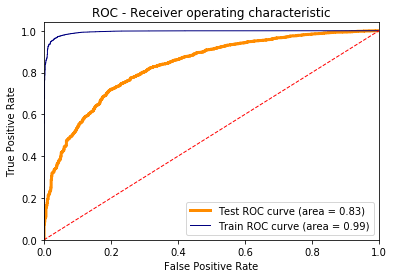

In [372]:
#https://qiita.com/bmj0114/items/460424c110a8ce22d945
Set8_Tr_prob    =  Xboost.predict_proba(X_AvgW2VtfIdf_Tr)    # Probablity of TRAIN-Validation
Set8_Tst_prob   =  Xboost.predict_proba(X_AvgW2VtfIdf_Test)    # Probablity of Cross-Validation

Set8_tst_fpr, Set8_tst_tpr, thresholds = roc_curve(Y_test,Set8_Tst_prob[:,1])
Set8_tst_roc_auc = auc(Set8_tst_fpr, Set8_tst_tpr)

Set8_train_fpr, Set8_train_tpr, thresholds = roc_curve(Y_tr,Set8_Tr_prob[:,1])
Set8_train_roc_auc = auc(Set8_train_fpr, Set8_train_tpr)


print(" Train Data      AUC for the Best Lamda  is ", Set8_train_roc_auc)
print(" Test Validaton  AUC for the BEst Lamda  is ", Set8_tst_roc_auc)

lw=1
plt.figure()
plt.plot(Set8_tst_fpr, Set8_tst_tpr, color='darkorange', lw=3, label='Test ROC curve (area = %0.2f)' % Set8_tst_roc_auc)
plt.plot(Set8_train_fpr, Set8_train_tpr, color='navy', lw=1, label='Train ROC curve (area = %0.2f)' % Set8_train_roc_auc)
plt.plot([0, 1], [0,1], color='red', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.04])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# [6] Conclusions

In [373]:
# Please compare all your models using Prettytable library